In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json
from rasterstats import zonal_stats
from rasterio.transform import from_origin


# gpd.version.version

Populating the interactive namespace from numpy and matplotlib


C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
print(os.getcwd())

B:\GitRepos\onhm-fetcher-parser-b\notebooks


# Open Gridmet max temperature with geopandas and plot

In [3]:
print(os.getcwd())
from pathlib import Path
folder = Path(r'../Data') # assumes working directory is onhm-fetcher-parser
print(folder)
shapefiles = folder.glob("*_0[1-2].shp")
#shapefiles = folder.glob("*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
#print(gdf)

B:\GitRepos\onhm-fetcher-parser-b\notebooks
..\Data


# Some testing with datetime to add to requests below

In [4]:
import time
import datetime as dt

dt1 = dt.timedelta(days = 1)
dt90 = dt.timedelta(days=92)

format="%Y-%m-%d"

today = dt.datetime.now()
end = dt.datetime.now()-dt1
start = dt.datetime.now()-dt90

print(type(today), today.strftime(format)+"T00:00:00Z")
print('start ', type(end.strftime(format)), start.strftime(format)+"T00:00:00Z")
print('end ', end.strftime(format)+"T00:00:00Z")

<class 'datetime.datetime'> 2019-05-29T00:00:00Z
start  <class 'str'> 2019-02-26T00:00:00Z
end  2019-05-28T00:00:00Z


# Open Gridmet data (as netcdf file) print out some metadata
This first bit of code follows examples from the following link:https://climate.northwestknowledge.net/MACA/OPENDAP.php
First we open the data set and inspect the metadata

In [5]:
import requests
from requests.exceptions import HTTPError

# delete existing file if it exists
exists = os.path.isfile(r'../Data/test2.nc')
if exists:
#     ds.close()
    os.remove(r'../Data/test2.nc')
    print('removed existing file')

# Url for non-aggragated
url = r'http://thredds.northwestknowledge.net:8080/thredds/ncss/MET/tmmn/tmmn_2019.nc'
payload={'var': 'air_temperature',
        'north': '49.4000',
        'west': '-124.7666',
        'east': '-67.0583',
        'south': '25.0666',
        'horizStride': '1',
        'time_start': start,
        'time_end': end,
        'timeStride': '1',
        'accept': 'netcdf4'}
# Note: when using the non-aggragated server, asking for dates in previous year fails.  Indicates
# that using the aggragated server would be the way to go when traversing a new calander year.

# Url for aggragated
url2 = 'http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc'
payload2={'var': 'daily_maximum_temperature',
        'north': '49.4000',
        'west': '-124.7666',
        'east': '-67.0583',
        'south': '25.0666',
        'disableLLSubset': 'on',
        'disableProjSubset': 'on',
        'horizStride': '1',
        'time_start': start,
        'time_end': end,
        'timeStride': '1',
        'accept': 'netcdf4'}
# print(url)
try:
#     myfile = requests.get(url, params=payload)
    myfile = requests.get(url2, params=payload2)
    myfile.raise_for_status()
except HTTPError as http_err:
    print(f'HTTP error occurred: {http_err}')  # Python 3.6
except Exception as err:
    print(f'Other error occurred: {err}')  # Python 3.6
else:
    print('Success!')
#     print(myfile.headers)
    print(myfile.url)
        
with open(r'../Data/test2.nc', 'wb') as fh:
    fh.write(myfile.content)
    fh.close()

ds = xr.open_dataset(r'../Data/test2.nc')
print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', json.dumps(ds.attrs, indent=4))
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['day']
# datahandle=ds['air_temperature'] # for non aggragated download
datahandle=ds['daily_maximum_temperature'] # for aggragated download
# crshandle=ds['crs']
# print('\n The crs meta data is \n', json.dumps(crshandle.attrs, indent=4))

# crstransform = crshandle.attrs['GeoTransform']
# print(crstransform)

#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])
lonres = float(ds.attrs['geospatial_lon_resolution'])
latres = float(ds.attrs['geospatial_lon_resolution'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
print('\n Data attributes are: \n', json.dumps(datahandle.attrs, indent=4))
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)

ts = datahandle.sizes
print(type(ts))
print(ts['day'])
dayshape = ts['day']
Lonshape = ts['lon']
Latshape = ts['lat']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)

# datahandle.values[dayshape-1,:,:].shape

# print(lathandle.values.shape)
# print(type(lathandle.values))
# print(datahandle.dtype)
# print(np.isfortran(datahandle.values))

Success!
http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc?var=daily_maximum_temperature&north=49.4000&west=-124.7666&east=-67.0583&south=25.0666&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2019-02-26+11%3A52%3A08.617734&time_end=2019-05-28+11%3A52%3A08.617734&timeStride=1&accept=netcdf4
<xarray.Dataset>
Dimensions:                    (day: 90, lat: 585, lon: 1386)
Coordinates:
  * day                        (day) datetime64[ns] 2019-02-27 ... 2019-05-27
  * lat                        (lat) float64 25.07 25.11 25.15 ... 49.36 49.4
  * lon                        (lon) float64 -124.8 -124.7 ... -67.1 -67.06
Data variables:
    daily_maximum_temperature  (day, lat, lon) float32 ...
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.0
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_ma

In [6]:
# temp testing and closeing xarray
# ds.close()

In [7]:
print(datahandle[dayshape-1, 480, 1232])

<xarray.DataArray 'daily_maximum_temperature' ()>
array(nan)
Coordinates:
    day      datetime64[ns] 2019-04-20
    lat      float64 45.07
    lon      float64 -73.43
Attributes:
    units:         K
    description:   Daily Maximum Temperature
    grid_mapping:  crs
    cell_methods:  time: maximum(interval: 24 hours)
    height:        2 m


# Add netcdf data (tmax here) to dataframe that has hru id and geometry
* use weight file to assign tmax

In [8]:
def testnan(value, weight):
    if np.isnan(value): 
        tvalue = 0.0
        tweight = 0.0
    else:
        tvalue = value
        tweight = weight
    return tvalue, tweight
    

In [9]:
# print(len(data))
# print(data.shape)
# print(data)

# Test with Pandas groupby alternative to original method in following cell

106320 109943 106320 109951
   grid_ids  hru_id_nat         w
0     586.0       82896  0.351084
1     587.0       82896  0.915412
2     588.0       82896  1.000000
3     589.0       82896  1.000000
4     590.0       82896  1.000000
[nan nan nan ... nan nan nan]
7289 109951
<class 'numpy.float64'>
min/max 5.612830334118598 24.63178509597202


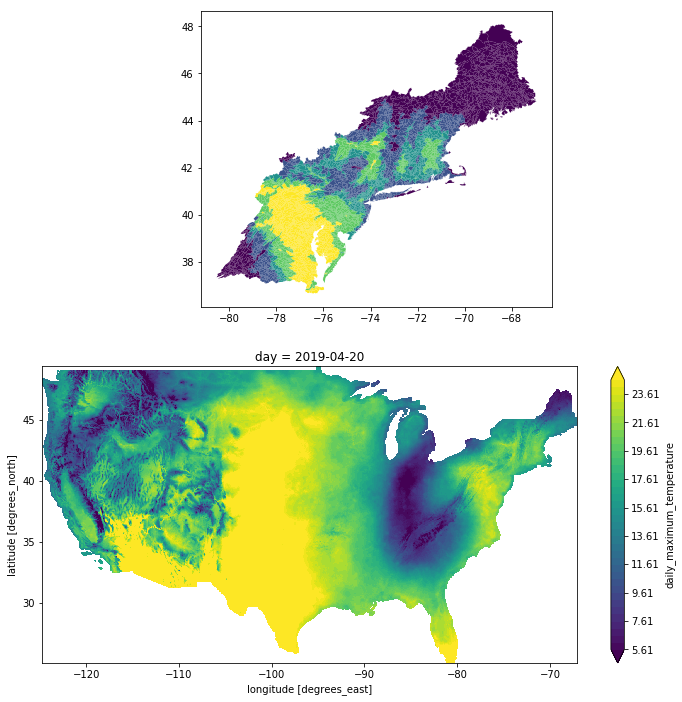

In [10]:
# add tmax column to dataframe
gdf['tmax']=0.0

#open weight data
wght_df = pd.read_csv('../Data/hru_metdata_weights.csv')
wght_df_40 = pd.read_csv('../Data/hru_metdata_weights_40m.csv')
wght_df_500 = pd.read_csv('../Data/hru_metdata_weights_500m.csv')
wght_UofI = pd.read_csv('../Data/hru_uofimetdata_weights.csv')
print(len(wght_df['hru_id_nat'].unique()), len(wght_df_40['hru_id_nat'].unique()), 
      len(wght_df_500['hru_id_nat'].unique()), len(wght_UofI['hru_id_nat'].unique()))
print(wght_UofI.head())

#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
ndata = datahandle.values[dayshape-1,:,:].flatten(order='K')
# ndata=np.nan_to_num(data)
print(ndata[1000:])
# def w_mean(data)
unique_hru_ids = wght_UofI.groupby('hru_id_nat')
print(len(gdf), len(unique_hru_ids))

def get_wval(grp, ndata):
    ttmax = twght = 0.0
    for index, row in grp.iterrows():
        ttmax += row['w']*ndata[np.int(row['grid_ids'])]
        twght += row['w']
    return ttmax/twght
def np_get_wval(grp, ndata):
    return np.average(ndata[grp['grid_ids'].values.astype(int)], weights=grp['w'])
def np_get_wval2(grp, ndata):
    mdata = np.ma.masked_array(ndata[grp['grid_ids'].values.astype(int)], np.isnan(ndata[grp['grid_ids'].values.astype(int)]))
    return np.ma.average(mdata, weights=grp['w'])
#     return np.average(ndata[grp['grid_ids'].values.astype(int)], weights=grp['w'])
    
# unique_hru_ids.get_group(gdf['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})    
td = np.zeros(len(gdf.index))
for index, row in gdf.iterrows():
    weight_id_rows = unique_hru_ids.get_group(row['hru_id_nat'])
#     print(weight_id_rows['grid_ids'].values.astype(int))
#     unique_hru_ids.get_group(row['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})
#     gdf.loc[gdf.index[index],'tmax'] = np_get_wval(weight_id_rows, ndata)-273.5
    tmp = np_get_wval2(weight_id_rows, ndata)-273.5
    if index == 1:
        print(type(tmp))
    td[index] = np_get_wval2(weight_id_rows, ndata)-273.5
#     if td[index] < 0.0:
#         print(ndata[weight_id_rows['grid_ids'].values.astype(int)], weight_id_rows['w'])
#     print(index, td[index])
#     if row['hru_id_nat'] == 829:
#         print("in test")
#         for i2, el in weight_id_rows.iterrows():
#             print(el['w'], ndata[el['grid_ids'].astype(int)])
#         print(np.average(ndata[weight_id_rows['grid_ids'].values.astype(int)], weights=weight_id_rows['w'])-273.5)
#     print(index, row['hru_id_nat'], np_get_wval(weight_id_rows, ndata)-273.5)
#     gdf.loc[gdf.index[index], 'tmax'] =
# #     print(get_wval(weight_id_rows, ndata)-273.5)
# #     row.loc['tmax']=get_wval(weight_id_rows, ndata)-273.5
# #     gdf.loc[gdf.index[index], 'tmax'] = get_wval(weight_id_rows, ndata)-273.5
# print(len(td))
# gdf['tmax'] = gpd.GeoSeries([np.transpose(td)], index=gdf.index)
gdf['tmax'] = td.tolist()
gdf['tmax'].fillna(0.0)
# print(td.tolist())
print('min/max', gdf['tmax'].min(), gdf['tmax'].max())
# print(gdf)
# gdf.plot(figsize=(12,12), column = 'tmax',linewidth=0.25, edgecolor='white')    
# print(gdf.groupby(tmax).min)
f, ax = plt.subplots(2, figsize=(12,12))
gdf.plot(ax=ax[0], column = 'tmax',linewidth=0., edgecolor='white', scheme='quantiles')
ptmax = ds.daily_maximum_temperature-273.5
ptmax_1 = ptmax.isel(day=dayshape-1)
lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)
ptmax_1.plot(ax=ax[1], levels=lvs, cmap='viridis')

In [18]:
# Alternative Rasterstats by opening netcdf directly rather than first saving to geotif
import rasterio
import rasterio.plot as rioplot
import cartopy.crs as ccrs

print(os.getcwd())
transform = from_origin( lonmin, latmax, lonres, latres)
# with rasterio.open(r'../Data/new.nc', driver='NetCDF') as src:
#     transformb = src.meta['transform']
#     print(type(transformb), src.meta)
#     array = src.read(1)
# rasterdata = rasterio.open(r'test1.tif')
# tmp = rioplot.show(rasterdata, with_bounds=True, cmap='viridis', extent=([-82, -70, 36, 46]))
# print(tmp.axis)
# tmp.set_xlim([-82, -70])
# tmp.set_ylim([36, 46])
hrudata = gpd.GeoDataFrame.from_file(r'../Data/nhru_02.shp')

stats = zonal_stats(hrudata, datahandle.values[dayshape-1,:,:].flatten(order='K'), 
                    transform=transform.to_gdal(), prefix='tmax_', 
                    all_touched=True, geojson_out=True)
# statsdf = pd.DataFrame(stats)
# src.close()
stats_gdf = gpd.GeoDataFrame.from_features(stats)
print(stats_gdf.head())
extent=([-82, -70, 36, 46])
f, ax = plt.subplots(1, figsize=(8,6))
ax.set_title("max temp")
stats_gdf.plot(ax=ax, column='tmax_mean', scheme='Equal_Interval', k=10, 
                   cmap='viridis', linewidth=0.25, edgecolor='black', 
                   legend=True, legend_kwds={'loc': 'upper left'})

C:\Users\rmcd\GitRepos\Python Projects\onhm-fetcher-parser\notebooks


ValueError: Must be a 2D or 3D array

# write netcdf file using netcdf4
* https://github.com/Unidata/netcdf4-python/blob/master/examples/writing_netCDF.ipynb

In [17]:
import netCDF4
try: ncfile.close() # just to be safe, make sure dataset is not already open.
except: pass
# ncfile = netCDF4.Dataset('new.nc',mode='w',format='NETCDF3_CLASSIC')
ncfile = netCDF4.Dataset('new.nc',mode='w',format='NETCDF4_CLASSIC')
# Global Attributes
ncfile.Conventions = 'CF-1.8'
ncfile.featureType = 'timeSeries'
ncfile.history = ''

sp_dim = len(gdf.index)
hruid_dim = ncfile.createDimension('hruid', sp_dim)     # hru_id
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print(dim)

#Create Variables
time = ncfile.createVariable('time', np.int, ('time', ))
time.long_name = 'time'
time.standard_name = 'time'
time.units = 'days since '+'base_date'+' 00:00'+'time_zone'

hru = ncfile.createVariable('hruid', np.int, ('hruid', ))
hru.cf_role = 'timeseries_id'
hru.long_name = 'local model hru id'

lat = ncfile.createVariable('hru_lat', np.float32, ('hruid',))
lat.long_name = 'Latitude of HRU centroid'
lat.units = 'degrees_north'
lat.standard_name = 'hru_latitude'

lon = ncfile.createVariable('hru_lon', np.float32, ('hruid',))
lon.long_name = 'Longitude of HRU centroid'
lon.units = 'degrees_east'
lon.standard_name = 'hru_longitude'

prcp = ncfile.createVariable('prcp', np.float32, ('time', 'hruid'))
prcp.long_name = 'Daily precipitation rate'
prcp.units = 'mm/day'
prcp.standard_name = 'lwe_precipitation_rate'

tmax = ncfile.createVariable('tmax', np.float32, ('time', 'hruid'))
tmax.long_name = 'Maximum daily air temperature'
tmax.units = 'degree_Celsius'
tmax.standard_name = 'maximum_daily_air_temperature'

tmin = ncfile.createVariable('tmin', np.float32, ('time', 'hruid'))
tmin.long_name = 'Minimum daily air temperature'
tmin.units = 'degree_Celsius'
tmin.standard_name = 'minimum_daily_air_temperature'

# fill variables with available data
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = gdf['geometry'].centroid
tlon, tlat = [list(t) for t  in zip(*map(getXY, centroidseries))]
# print(lon, lat)
lon[:] = tlon
lat[:] = tlat
hru[:] = gdf['hru_id_nat'].values
# print(hruid)
tmax[0,:] = gdf['tmax'].values

print(ncfile)
ncfile.close(); print("dataset is closed")


('hruid', <class 'netCDF4._netCDF4.Dimension'>: name = 'hruid', size = 7289
)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0
)
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.8
    featureType: timeSeries
    history: 
    dimensions(sizes): hruid(7289), time(1)
    variables(dimensions): int32 time(time), int32 hruid(hruid), float32 hru_lat(hruid), float32 hru_lon(hruid), float32 prcp(time,hruid), float32 tmax(time,hruid), float32 tmin(time,hruid)
    groups: 

dataset is closed
